In [1]:
from tensorflow import keras
import tensorflow as tf
import pathlib
import os

import numpy as np

BATCH_SIZE = 32
EPOCHS = 100
LR = 0.003
WEIGHT_DECAY = 0.0001

In [2]:
@keras.utils.register_keras_serializable(package="resmlp")
class ChannelAffine(keras.layers.Layer):
    def __init__(self, use_bias=True, weight_init_value=1, **kwargs):
        super(ChannelAffine, self).__init__(**kwargs)
        self.use_bias, self.weight_init_value = use_bias, weight_init_value
        self.ww_init = keras.initializers.Constant(weight_init_value) if weight_init_value != 1 else "ones"
        self.bb_init = "zeros"
        self.supports_masking = False

    def build(self, input_shape):
        self.ww = self.add_weight(name="weight", shape=(input_shape[-1]), initializer=self.ww_init, trainable=True)
        if self.use_bias:
            self.bb = self.add_weight(name="bias", shape=(input_shape[-1]), initializer=self.bb_init, trainable=True)
        super(ChannelAffine, self).build(input_shape)

    def call(self, inputs, **kwargs):
        return inputs * self.ww + self.bb if self.use_bias else inputs * self.ww

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(ChannelAffine, self).get_config()
        config.update({"use_bias": self.use_bias, "weight_init_value": self.weight_init_value})
        return config

In [3]:
@keras.utils.register_keras_serializable(package="resmlp")
class BiasLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BiasLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bias = self.add_weight('bias',
                                    shape=input_shape[-1],
                                    initializer='zeros')
    def call(self, x):
        return tf.nn.bias_add(x, self.bias)
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        config = super(BiasLayer, self).get_config()
        return config

In [4]:
from tensorflow import keras
import os

def res_mlp_block(inputs, channels_mlp_dim, drop_rate=0, activation="gelu", name=None):
    nn = ChannelAffine(use_bias=True, name=name + "norm_1")(inputs)
    nn = keras.layers.Permute((2, 1), name=name + "permute_1")(nn)
    nn = keras.layers.Dense(nn.shape[-1], name=name + "token_mixing")(nn)
    nn = keras.layers.Permute((2, 1), name=name + "permute_2")(nn)
    nn = ChannelAffine(use_bias=False, name=name + "gamma_1")(nn)
    if drop_rate > 0:
        nn = keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1), name=name + "token_drop")(nn)
    token_out = keras.layers.Add(name=name + "add_1")([inputs, nn])

    nn = ChannelAffine(use_bias=True, name=name + "norm_2")(token_out)
    
    nn = keras.layers.Dense(channels_mlp_dim//2, name=name + "channel_mixing_1")(nn)
    #n1 = keras.layers.Dense(channels_mlp_dim//2, use_bias=False, name=name + "channel_mixing_1-1")(nn)
    #n2 = keras.layers.Dense(channels_mlp_dim//2, use_bias=False, name=name + "channel_mixing_1-2")(nn)
    #nn = keras.layers.Concatenate(name=name + "concat")([n1, n2])
    #nn = BiasLayer(name=name + "bias")(nn)
    
    nn = keras.layers.Activation(activation, name=name + activation)(nn)
    nn = keras.layers.Dense(inputs.shape[-1], name=name + "channel_mixing_2")(nn)
    channel_out = ChannelAffine(use_bias=False, name=name + "gamma_2")(nn)
    if drop_rate > 0:
        channel_out = keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1), name=name + "channel_drop")(channel_out)
    nn = keras.layers.Add(name=name + "add_2")([channel_out, token_out])
    return nn


def ResMLP(
    num_blocks,
    batch_size,
    patch_size,
    stem_width,
    channels_mlp_dim,
    input_shape=(224, 224, 3),
    num_classes=0,
    activation="gelu",
    sam_rho=0,
    dropout=0,
    drop_connect_rate=0,
    classifier_activation="softmax",
    pretrained="imagenet",
    model_name="resmlp",
    kwargs=None,
):
    inputs = keras.Input(input_shape, batch_size=batch_size)
    nn = keras.layers.Conv2D(stem_width, kernel_size=patch_size, strides=patch_size, padding="valid", name="stem")(inputs)
    nn = keras.layers.Reshape([nn.shape[1] * nn.shape[2], stem_width])(nn)

    drop_connect_s, drop_connect_e = drop_connect_rate if isinstance(drop_connect_rate, (list, tuple)) else [drop_connect_rate, drop_connect_rate]
    for ii in range(num_blocks):
        name = "{}_{}_".format("ResMlpBlock", str(ii + 1))
        block_drop_rate = drop_connect_s + (drop_connect_e - drop_connect_s) * ii / num_blocks
        nn = res_mlp_block(nn, channels_mlp_dim=channels_mlp_dim, drop_rate=block_drop_rate, activation=activation, name=name)
    nn = ChannelAffine(name="pre_head_norm")(nn)

    if num_classes > 0:
        # nn = tf.reduce_mean(nn, axis=1)
        nn = keras.layers.GlobalAveragePooling1D()(nn)
        if dropout > 0 and dropout < 1:
            nn = keras.layers.Dropout(dropout)(nn)
        nn = keras.layers.Dense(num_classes, activation=classifier_activation, name="predictions")(nn)

    if sam_rho != 0:
        from keras_mlp import SAMModel

        model = SAMModel(inputs, nn, name=model_name)
    else:
        model = keras.Model(inputs, nn, name=model_name)
    reload_model_weights(model, input_shape, pretrained)
    return model


def reload_model_weights(model, input_shape=(224, 224, 3), pretrained="imagenet"):
    pretrained_dd = {
        "resmlp12": ["imagenet"],
        "resmlp24": ["imagenet"],
        "resmlp36": ["imagenet"],
        "resmlp_b24": ["imagenet", "imagenet22k"],
    }
    if model.name not in pretrained_dd or pretrained not in pretrained_dd[model.name]:
        print(">>>> No pretraind available, model will be randomly initialized")
        return

    pre_url = "https://github.com/leondgarse/keras_mlp/releases/download/resmlp/{}_{}.h5"
    url = pre_url.format(model.name, pretrained)
    file_name = os.path.basename(url)
    try:
        pretrained_model = keras.utils.get_file(file_name, url, cache_subdir="models")
    except:
        print("[Error] will not load weights, url not found or download failed:", url)
        return
    else:
        print(">>>> Load pretraind from:", pretrained_model)
        model.load_weights(pretrained_model, by_name=True, skip_mismatch=True)


BLOCK_CONFIGS = {
    "edge": {
        "num_blocks": 12,
        "patch_size": 22,
        "stem_width": 200,
        "channels_mlp_dim": 200 * 4,
    },
    "12": {
        "num_blocks": 12,
        "patch_size": 16,
        "stem_width": 384,
        "channels_mlp_dim": 384 * 4,
    },
    "24": {
        "num_blocks": 24,
        "patch_size": 16,
        "stem_width": 384,
        "channels_mlp_dim": 384 * 4,
    },
    "36": {
        "num_blocks": 36,
        "patch_size": 16,
        "stem_width": 384,
        "channels_mlp_dim": 384 * 4,
    },
    "b24": {
        "num_blocks": 24,
        "patch_size": 8,
        "stem_width": 768,
        "channels_mlp_dim": 768 * 4,
    },
}

def ResMLPedge(input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained="imagenet", **kwargs):
    return ResMLP(**BLOCK_CONFIGS["edge"], **locals(), model_name="resmlpedge", **kwargs)



def ResMLP12(input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained="imagenet", **kwargs):
    return ResMLP(**BLOCK_CONFIGS["12"], **locals(), model_name="resmlp12", **kwargs)


def ResMLP24(input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained="imagenet", **kwargs):
    return ResMLP(**BLOCK_CONFIGS["24"], **locals(), model_name="resmlp24", **kwargs)


def ResMLP36(input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained="imagenet", **kwargs):
    return ResMLP(**BLOCK_CONFIGS["36"], **locals(), model_name="resmlp36", **kwargs)


def ResMLP_B24(input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained="imagenet", **kwargs):
    return ResMLP(**BLOCK_CONFIGS["b24"], **locals(), model_name="resmlp_b24", **kwargs)

In [5]:
model = ResMLPedge(
    input_shape=(224, 224, 3), 
    batch_size = None,
    num_classes=10, 
    activation="relu", 
    classifier_activation="softmax", 
    pretrained="imagenet",
)
model.load_weights("my_mlp.h5", by_name=True, skip_mismatch=True)

>>>> No pretraind available, model will be randomly initialized


In [6]:
for layer in model.layers:
    layer.trainable = False
    
model.layers[-1].get_config()
model.layers[-1].trainable = True
model.summary()

Model: "resmlpedge"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem (Conv2D)                  (None, 10, 10, 200)  290600      ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 100, 200)     0           ['stem[0][0]']                   
                                                                                                  
 ResMlpBlock_1_norm_1 (ChannelA  (None, 100, 200)    400         ['reshape[0][0]']       

 ffine)                                                                                           
                                                                                                  
 ResMlpBlock_3_permute_1 (Permu  (None, 200, 100)    0           ['ResMlpBlock_3_norm_1[0][0]']   
 te)                                                                                              
                                                                                                  
 ResMlpBlock_3_token_mixing (De  (None, 200, 100)    10100       ['ResMlpBlock_3_permute_1[0][0]']
 nse)                                                                                             
                                                                                                  
 ResMlpBlock_3_permute_2 (Permu  (None, 100, 200)    0           ['ResMlpBlock_3_token_mixing[0][0
 te)                                                             ]']                              
          

 ResMlpBlock_5_gamma_1 (Channel  (None, 100, 200)    200         ['ResMlpBlock_5_permute_2[0][0]']
 Affine)                                                                                          
                                                                                                  
 ResMlpBlock_5_add_1 (Add)      (None, 100, 200)     0           ['ResMlpBlock_4_add_2[0][0]',    
                                                                  'ResMlpBlock_5_gamma_1[0][0]']  
                                                                                                  
 ResMlpBlock_5_norm_2 (ChannelA  (None, 100, 200)    400         ['ResMlpBlock_5_add_1[0][0]']    
 ffine)                                                                                           
                                                                                                  
 ResMlpBlock_5_channel_mixing_1  (None, 100, 400)    80400       ['ResMlpBlock_5_norm_2[0][0]']   
  (Dense) 

                                                                                                  
 ResMlpBlock_7_relu (Activation  (None, 100, 400)    0           ['ResMlpBlock_7_channel_mixing_1[
 )                                                               0][0]']                          
                                                                                                  
 ResMlpBlock_7_channel_mixing_2  (None, 100, 200)    80200       ['ResMlpBlock_7_relu[0][0]']     
  (Dense)                                                                                         
                                                                                                  
 ResMlpBlock_7_gamma_2 (Channel  (None, 100, 200)    200         ['ResMlpBlock_7_channel_mixing_2[
 Affine)                                                         0][0]']                          
                                                                                                  
 ResMlpBlo

                                                                  'ResMlpBlock_9_add_1[0][0]']    
                                                                                                  
 ResMlpBlock_10_norm_1 (Channel  (None, 100, 200)    400         ['ResMlpBlock_9_add_2[0][0]']    
 Affine)                                                                                          
                                                                                                  
 ResMlpBlock_10_permute_1 (Perm  (None, 200, 100)    0           ['ResMlpBlock_10_norm_1[0][0]']  
 ute)                                                                                             
                                                                                                  
 ResMlpBlock_10_token_mixing (D  (None, 200, 100)    10100       ['ResMlpBlock_10_permute_1[0][0]'
 ense)                                                           ]                                
          

 ResMlpBlock_12_permute_2 (Perm  (None, 100, 200)    0           ['ResMlpBlock_12_token_mixing[0][
 ute)                                                            0]']                             
                                                                                                  
 ResMlpBlock_12_gamma_1 (Channe  (None, 100, 200)    200         ['ResMlpBlock_12_permute_2[0][0]'
 lAffine)                                                        ]                                
                                                                                                  
 ResMlpBlock_12_add_1 (Add)     (None, 100, 200)     0           ['ResMlpBlock_11_add_2[0][0]',   
                                                                  'ResMlpBlock_12_gamma_1[0][0]'] 
                                                                                                  
 ResMlpBlock_12_norm_2 (Channel  (None, 100, 200)    400         ['ResMlpBlock_12_add_1[0][0]']   
 Affine)  

In [7]:
import tensorflow_datasets as tfds

data_dir = 'E:\imagenet'

(ds_train, ds_val), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    data_dir=data_dir, 
    as_supervised=True,
    with_info=True,
    #batch_size=BATCH_SIZE
)

STEPS = EPOCHS * len(ds_train) // BATCH_SIZE
print("STEPS:", STEPS)

STEPS: 156250


In [15]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 10
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds_one = (
    ds_train #tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    ds_train #tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = ds_train

test_ds = ds_val

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

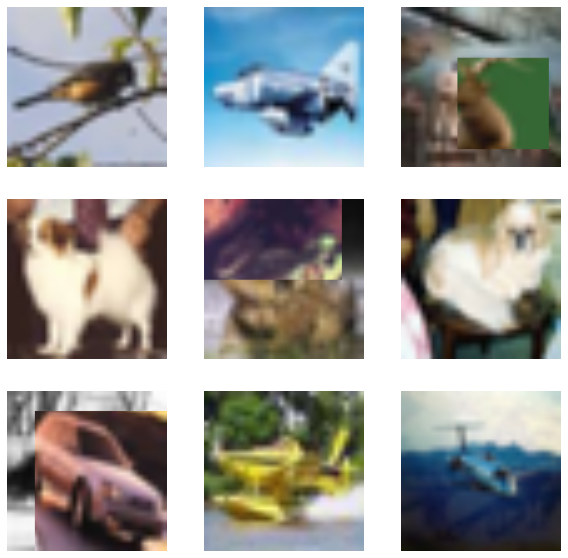

In [9]:
import matplotlib.pyplot as plt

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two, alpha=0.25, beta = 0.25):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2

    return image, label

@tf.function
def mix_up(train_ds_one, train_ds_two, alpha=0.2):
    # Unpack two datasets
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    lambda_value = sample_beta_distribution(1, alpha, alpha)
    
    # Define Lambda
    lambda_value = lambda_value[0]

    image = image1 * lambda_value + image2 * (1 - lambda_value)

    # Lambda cast
    lambda_value = tf.cast(lambda_value, tf.float32)
    
    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
        
    return (image, label)

 
#!pip install -q tf-models-official tensorflow-addons
# from official.vision.image_classification.augment import RandAugment
# augmenter = RandAugment(num_layers=2, magnitude=9)

# @tf.function
# def randAug(train_ds, prob=0.3):
#     # Unpack two datasets
#     (image, label) = train_ds
#     randval = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    
#     if (tf.math.less(randval, tf.constant(0.5, dtype=tf.float32))):
#         return (augmenter.distort(image), label)
#     else:
#         return (image, label)


@tf.function
def cutmix_or_mixup(ds_one, ds_two):
    randval = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    if (tf.math.less(randval, tf.constant(0.333, dtype=tf.float32))):
        (image, label) = cutmix(ds_one, ds_two)
    elif (tf.math.less(randval, tf.constant(0.666, dtype=tf.float32))):
        (image, label) = mix_up(ds_one, ds_two)
    
    #if (tf.math.less(randval, tf.constant(0.5, dtype=tf.float32))):
        #return (augmenter.distort(image), label)
    else:
        (image, label) = ds_one
    
    return (image, label)


train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix_or_mixup, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)



# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(min(9, BATCH_SIZE)):
    ax = plt.subplot(3, 3, i + 1)
    #plt.title(labels[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [12]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/")

from tensorflow_addons.optimizers import AdamW

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=LR, decay_steps=STEPS)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, decay=0, momentum=0.9)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="acc"),
        tf.keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
    ],
)

model.fit(
    train_ds_cmu,
    validation_data=test_ds,
    epochs=EPOCHS,
    
    callbacks=[tb_callback]
)

C:\Users\scott\.conda\envs\tf-2.6\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.9.0-dev20211225). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [33]:
model.save_weights("cifar10")

In [10]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Representative dataset
def representative_dataset(dataset):
    def _data_gen():
        for data in dataset.batch(1):
            sample = data['image'].astype(np.float32)
            yield [sample]

    return _data_gen

def process_image(data):
    data['image'] = tf.image.resize(data['image'], (224, 224)) / 255.0
    return data

[ds] = tfds.load(
    'imagenet2012',
    split=['validation[:1%]'],
    shuffle_files=True,
    data_dir=data_dir, 
)
ds_test = ds.map(process_image)

model = ResMLPedge(
    input_shape=(224, 224, 3), 
    batch_size = 1,
    num_classes=10, 
    activation="relu", 
    classifier_activation="softmax", 
    pretrained=None,
)

model.load_weights("cifar10")

>>>> No pretraind available, model will be randomly initialized


In [17]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="acc"),
        tf.keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
    ],
)

model.evaluate(test_ds)

10000/10000 [==============================] - 127s 12ms/step - loss: 0.7010 - acc: 0.7630 - top5-acc: 0.9861


[0.7010125517845154, 0.7630000114440918, 0.9861000180244446]

In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset(ds_test)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
tflite_model_quant_file = pathlib.Path('resmlp_relu.tflite')
tflite_model_quant_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\scott\AppData\Local\Temp\tmpzkjjf03c\assets


INFO:tensorflow:Assets written to: C:\Users\scott\AppData\Local\Temp\tmpzkjjf03c\assets
C:\Users\scott\.conda\envs\tf-2.6\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


2426376